# 04 - Full Waveform Inversion with Devito and Dask

## Introduction


In this tutorial, we will build on the [previous](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/03_fwi.ipynb) FWI tutorial and implement parallel versions of both forward modeling and FWI objective functions. Furthermore, we will show how our parallel FWI function can be passed to black-box third party optimization libraries, such as scipy's [optimize](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html) package, to access sophisticated optimization algorithms without having to implement them from scratch!

To implement parallel versions of forward modeling and FWI, we will use [Dask](https://dask.pydata.org/en/latest/#dask), a Python library for distributed computing based on parallel data structures and task-based programming. As computing multiple seismic shot records or gradients for subsequent source locations is an embarassingly parallel process, we will use Dask to dynamically distribute our workload to a pool of available workers and afterwards collect the results.

The first part of this tutorial closely follows [tutorial 3](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/03_fwi.ipynb) and consists of reading the velocity model and setting up the acquisition geometry. Subsequently, we will implement serial versions of forward modeling and FWI objective functions and then show how we can use Dask to implement parallel versions of these functions. Finally, we will show how to write a wrapper that lets us pass our objective function to scipy's optimize package and how to run a small 2D FWI example using a limited-memory Quasi-Newton method.

## Set up velocity models

As before, we start by reading the true (i.e. unknown) velocity model, as well as the starting model for FWI. For our example, we once again use the 2D Camembert model with a transmission acquisition set up, which involves having sources on one side of the model and receivers on the other side.

In reality, we obvisouly cannot know what the true velocity is, but here we use the true model to generate our own data (inverse crime alert!) and to compare it to our FWI result.

In [1]:
from examples.seismic import demo_model

# Set up velocity model
shape = (101, 101)      # Number of grid points (nx, nz).
spacing = (10., 10.)    # Grid spacing in m. The domain size is now 1km by 1km.
origin = (0, 0)         # Need origin to define relative source and receiver locations.
nbl = 40

# True model
model = demo_model('circle-isotropic', vp_circle=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbl=40)

# Initial model
model0 = demo_model('circle-isotropic', vp_circle=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbl=40,
                    grid = model.grid)

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s


## Acquisition geometry

For the acquisition geometry, we use the same setup as in tutorial 3 and put 5 source position on one side of the model, and an array of 101 receivers on the other side. Note that now our source coordinate array (`src_coordinates`) is a 5 x 2 array, containing the shot locations of all 5 source experiments. After defining the source/receiver coordinates, we set up individual geometry objects for both the observed data (using `model`) and the predicted data (using `model0`).

In [2]:
from examples.seismic import AcquisitionGeometry
import numpy as np

# Set up acquisiton geometry
t0 = 0.
tn = 1000. 
f0 = 0.010

# Set up source geometry, but define 5 source instead of just one.
nsources = 5
src_coordinates = np.empty((nsources, 2))
src_coordinates[:, 1] = np.linspace(spacing[0], model.domain_size[0] - spacing[0], num=nsources)
src_coordinates[:, 0] = 20.  # Source depth is 20m

# Initialize receivers for synthetic and imaging data
nreceivers = 101
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 1] = np.linspace(spacing[1], model.domain_size[0] - spacing[1], num=nreceivers)
rec_coordinates[:, 0] = 980.    # Receiver depth

# Set up geometry objects for observed and predicted data
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
geometry0 = AcquisitionGeometry(model0, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')

## Forward modeling

Before diving into FWI, we will start with forward modeling and show how we can use Dask to implement a parallel wrapper around a serial modeling function to compute seismic shot records for multiple source locations in parallel.

First, we implement a serial forward modeling function, which takes a geometry data structure as the only mandatory input argument. This function assumes that the geometry structure only contains a *single* source location. The function solves the wave equation for the location and model that are specified in `geometry` and returns a single shot record and wavefield.

In [3]:
from examples.seismic.acoustic import AcousticWaveSolver

# Serial modeling function
def forward_modeling_serial(geometry, save=False, dt=4.0):
    solver = AcousticWaveSolver(geometry.model, geometry, space_order=4)
    d_obs, u0 = solver.forward(vp=geometry.model.vp, save=save)[0:2]
    return d_obs.resample(dt), u0

With our serial modeling function in place, we now implement our parallel version of our modeling function, which consists of a loop over all source locations. As the `geometry` object in `forward_modeling_serial` expects only a single source location, we set up a new geometry structure for the i-th source location and pass it to the serial modeling function. However, rather than simpling calling the serial function, we tell Dask to create a *task* for each source location and to distribute them to the available parallel workers. Dask returns a remote reference  to the result on each worker called `future`. The `wait` statement tells our function to wait for all tasks to finish their computations, after which we collect the modeled shot records from the workers.

In [4]:
# Parallel modeling function
def forward_modeling_parallel(geometry, save=False, dt=4.0):

    futures = []
    for i in range(geometry.nsrc):

        # Geometry for current shot
        geometry_i = AcquisitionGeometry(geometry.model, geometry.rec_positions, geometry.src_positions[i, :], 
            geometry.t0, geometry.tn, f0=geometry.f0, src_type=geometry.src_type)
        
        # Call serial modeling function for each index
        futures.append(client.submit(forward_modeling_serial, geometry_i, save=save, dt=dt))

    # Wait for all workers to finish and collect shots
    wait(futures)
    shots = []
    for i in range(geometry.nsrc):
        shots.append(futures[i].result()[0])

    return shots

We can use this parallel modeling function to generate our own observed data set, which we will subsequently use for our FWI example. In reality, we would instead read our observed data from a SEG-Y file. To compute the data in parallel, we launch a pool of workers on our local machine and then call the parallel modeling function:

In [5]:
#NBVAL_IGNORE_OUTPUT
from distributed import Client, LocalCluster, wait

# Start Dask cluster
cluster = LocalCluster(n_workers=nsources, death_timeout=600)
client = Client(cluster)

# Compute observed data in parallel (inverse crime). In real life we would read the SEG-Y data here.
d_obs = forward_modeling_parallel(geometry, save=False)

The variable `d_obs` is a list of the 5 shots records and we can plot one of the shot records as follows:

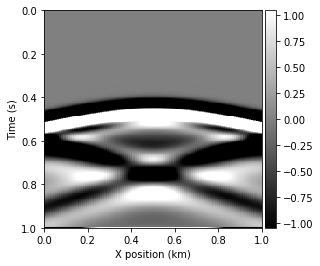

In [6]:
from examples.seismic import plot_shotrecord

# Plot shot no. 3 of 5
plot_shotrecord(d_obs[2].data, model, t0, tn)

## Parallel Full-Waveform Inversion

Now that we know how to use Dask to implement a parallel wrapper around a serial modeling function, we can apply the same concept to an FWI objective function, which computes the FWI function value and gradient for a given geometry and observed shot record. This function follows largely the structure in tutorial 3 and involves computing the predicted data and backpropagating the residual to compute the gradient. As we do not want to update the velocity in the area of the absorbing boundaries, we only return the gradient on the (original) physical grid.

In [7]:
from devito import Function
from examples.seismic import Receiver

# Serial FWI objective function
def fwi_objective_serial(geometry, d_obs):

    # Devito objects for gradient and data residual
    grad = Function(name="grad", grid=model.grid)
    residual = Receiver(name='rec', grid=model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    solver = AcousticWaveSolver(geometry.model, geometry, space_order=4)

    # Predicted data and residual
    d_pred, u0 = solver.forward(vp=geometry.model.vp, save=True)[0:2]
    residual.data[:] = d_pred.data[:] - d_obs.resample(geometry.dt).data[:][0:d_pred.data.shape[0], :]

    # Function value and gradient    
    fval = .5*np.linalg.norm(residual.data.flatten())**2
    solver.gradient(rec=residual, u=u0, vp=geometry.model.vp, grad=grad)
    
    # Convert to numpy array and remove absorbing boundaries
    grad_crop = np.array(grad.data[:])[model.nbl:-model.nbl, model.nbl:-model.nbl]
    
    return fval, grad_crop

As for the serial modeling function, we can call `fwi_objective_serial` with a geometry structure containing a single source location and a single observed shot record. Since we are interested in evaluating this function for multiple sources, we follow the strategy from our parallel forward modeling function and implement a loop over all shots, in which we create a task for each shot location. As before, we use Dask to create one task per shot location and evaluate the serial FWI objective function for each source. We wait for all computations to finish via `wait(futures)` and then we sum the function values and gradients from all workers.

In [8]:
# Parallel FWI objective function
def fwi_objective_parallel(geometry, d_obs):

    futures = []
    for i in range(geometry.nsrc):

        # Geometry for current shot
        geometry_i = AcquisitionGeometry(geometry.model, geometry.rec_positions, geometry.src_positions[i, :], 
            geometry.t0, geometry.tn, f0=geometry.f0, src_type=geometry.src_type)
        
        # Call serial FWI objective function for each shot location
        futures.append(client.submit(fwi_objective_serial, geometry_i, d_obs[i]))

    # Wait for all workers to finish and collect function values and gradients
    wait(futures)
    fval = 0.0
    grad = np.zeros(geometry.model.shape)
    for i in range(geometry.nsrc):
        fval += futures[i].result()[0]
        grad += futures[i].result()[1]

    return fval, grad

We can compute a single gradient of the FWI objective function by passing the geometry structure with the initial model to the objective function, as well as the observed data we generated earlier.

In [9]:
#NBVAL_IGNORE_OUTPUT

# Compute FWI gradient for 5 shots
f, g = fwi_objective_parallel(geometry0, d_obs)

The physical units of the gradient are $s^2/km^2$, which means our gradient is an update of the squared slowness, rather than of the velocity.

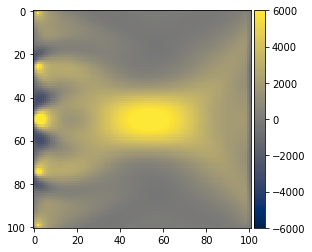

In [10]:
from examples.seismic import plot_image

# Plot g
plot_image(g.reshape(model.shape), vmin=-6e3, vmax=6e3, cmap="cividis")

## FWI with scipy's L-BFGS


With our parallel FWI objective function in place, we can in principle implement a wide range of gradient-based optimization algorithms for FWI, such as (stochastic) gradient descent or the nonlinear conjugate gradient method. However, many optimization algorithms, especially second order methods or algorithms for constrained optimization, are far from trivial to implement correctly from scratch. Luckily, many optimization libraries exist that we can adapt for our purposes. 

Here, we demonstrate how we can interface the scipy *optimize* package to run FWI with a limited-memory Quasi-Newton method. The scipty optimize package was not specifically designed for FWI, but this does not matter, as the library simply execpts any Python function that can be evaluated for a current model iterate `x` and returns the function value and gradient:

```
f, g = objective_function(x, args)
```

where `f` is function value and `g` is a one-dimensional numpy array of type `float64`. Our parallel FWI function does not take the current model as an input argument, but instead expects a geometry structure and the observed data. Therefore have to write a little wrapper function called `loss`, which provides the input argument structure that is expected by `scipy.optimize`. The function takes the current model iteratve `x` (in squared slowness) as the first input argument and overwrites the current velocity in `geometry` with `x`. The gradient that is returned to `scipy.optimize` is converted to a numpy array of the required type (`float64`).

In [11]:
# Wrapper for scipy optimizer: x is current model in squared slowness [s^2/km^2]
def loss(x, geometry, d_obs):
    
    # Convert x to velocity
    v_curr = 1.0/np.sqrt(x.reshape(geometry.model.shape))
    
    # Overwrite current velocity in geometry (don't update boundary region)
    geometry.model.vp.data[model.nbl:-model.nbl, model.nbl:-model.nbl] = v_curr
    
    # Evaluate objective function 
    fval, grad = fwi_objective_parallel(geometry, d_obs)
    return fval, grad.flatten().astype(np.float64)    # scipy expects double precision vector

The `scipy.optimize` function also takes an optional callback function as an input argument, which can be used to keep track of the model error as a function of the iteration number. The callback function takes the current model iterate `xk` as the only input argument and computes the $\ell_2$-misfit with the true model `m`:

In [12]:
# Callback to track model error
model_error = []
def fwi_callback(xk):
    vp = model.vp.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
    m = 1.0 / (vp.reshape(-1).astype(np.float64))**2
    model_error.append(np.linalg.norm((xk - m)/m))

The final preparation step before we can run our example, is the definition of box constraints for the velocity. At each iteration, the optimizer will project the current model iterate onto a feasible set of velocites as defined by the lower and upper bounds `vmin` and `vmax`. Box contraints allow us to prevent velocites from taking negative values or values that are too small or large for the stabbility criteria of our modeling stepping scheme. We define the box constraints for the velocity in $km/s$ and then convert them to squared slownesses. Furthermore, we define our initial guess `m0`:

In [13]:
# Box contraints
vmin = 1.4    # do not allow velocities slower than water
vmax = 4.0
bounds = [(1.0/vmax**2, 1.0/vmin**2) for _ in range(np.prod(model0.shape))]    # in [s^2/km^2]

# Initial guess
v0 = model0.vp.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
m0 = 1.0 / (v0.reshape(-1).astype(np.float64))**2

Finally, we run our 2D FWI example by calling the `optimize.minimize` function. The first input argument is the function to be minimized, which is our `loss` function. The second input argument is the starting value, which in our case is our initial model in squared slowness. The third input argument (`args`) are the arguments that are passed to the loss function other than `x`. For this example we the L-BFGS algorithm, a limited-memory Quasi-Newton algorithm which builds up an approximation of the (inverse) hessian as we iterate. As our `loss` function returns the analytically computed gradient (as opposed to a numerically approximated gradient), we set the argument `jac=True`. Furthermore, we pass our callback function, box constraints and the maximum number of iterations (in this case 5) to the optimizer. 

In [14]:
#NBVAL_IGNORE_OUTPUT
from scipy import optimize

# FWI with L-BFGS
ftol = 0.1
maxiter = 5
result = optimize.minimize(loss, m0, args=(geometry0, d_obs), method='L-BFGS-B', jac=True, 
    callback=fwi_callback, bounds=bounds, options={'ftol':ftol, 'maxiter':maxiter, 'disp':True})

After either the maximum iteration number is reached or we find the minimum of the objective function within some tolerance level `ftol`, the optimizer returns a dictionary with the results and some additional information. We convert the result back to the velocity in $km/s$ and compare it to the true model:

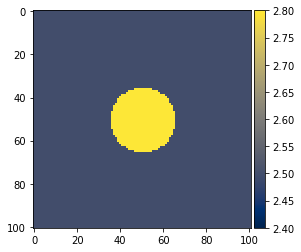

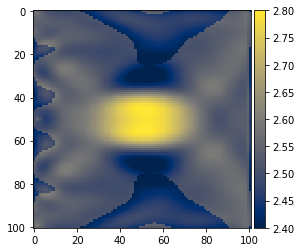

In [15]:
#NBVAL_IGNORE_OUTPUT

# Plot FWI result
vp = 1.0/np.sqrt(result['x'].reshape(model.shape))
plot_image(model.vp.data[model.nbl:-model.nbl, model.nbl:-model.nbl], vmin=2.4, vmax=2.8, cmap="cividis")
plot_image(vp, vmin=2.4, vmax=2.8, cmap="cividis")

Looking at the model error as a function of the iteration number, we find that the error decays monotonically, as we would expect.

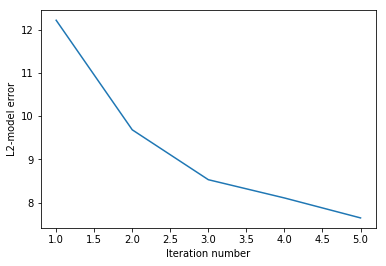

In [16]:
import matplotlib.pyplot as plt

# Plot model error
plt.plot(range(1, maxiter+1), model_error); plt.xlabel('Iteration number'); plt.ylabel('L2-model error')
plt.show()

## Next steps

In our current example, the master process keeps all shot records in memory and distributes the data to the workers in the parallel pool. This works perfectly fine for 2D and even small 3D examples, but quickly becomes infeasible for large-scale data sets. Therefore, an extension of our current code should include the following steps if we want to scale things up in the future:

 - Write shot records directly to disk on each worker and return a file pointer back to the master process.
 
 - Avoid sending the velocity model to the workers and read the model directly onto each worker.
 
 - Include optimal checkpointing or domain-decomposition to address the memory bottleneck in the gradient computations.